In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from functions import hid_var_data 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal

%matplotlib inline

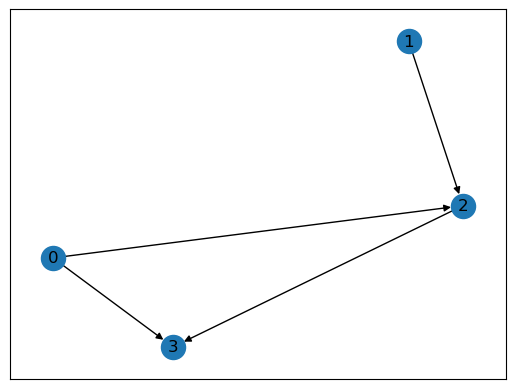

In [3]:
iv_adj = np.array([[0,0,1,1],[0,0,1,0],[0,0,0,1],[0,0,0,0]])
graph = nx.DiGraph(iv_adj)
nx.draw_networkx(graph)

latent = 1
observed = 3
n_samples = 10000
lambdas = [0,10]
moms = [0,1]
lr = 0.01
epochs = 100
w_init = 'given'
pseudoinverse = False
withening = True

data, params, W_with, w_true = hid_var_data(latent, observed, graph, n_samples, withening)

In [4]:
class Sources(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Sources, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [5]:
def kernel(x, y, sigma=1):
    log_val = -torch.sum((x - y)**2) / (2*sigma)
    return torch.exp(log_val)

def kernel_trick(x, y, sigma):
    n = x.shape[0]
    m = y.shape[0]
    loss = 0
    for x_row in x:
        for y_row in y:
            loss += kernel(x_row, y_row, sigma)
    
    loss /= n*m
    return loss

In [6]:
# Generate a batch of i.i.d samples from Gaussian distribution
source_dim = 4
m = MultivariateNormal(torch.zeros(source_dim), torch.eye(source_dim))

In [7]:
input_dim = 1
output_dim = 1
hidden_dim = 5
source0 = Sources(input_dim, output_dim, hidden_dim)
source1 = Sources(input_dim, output_dim, hidden_dim)
source2 = Sources(input_dim, output_dim, hidden_dim)
source3 = Sources(input_dim, output_dim, hidden_dim)
sources = [source0, source1, source2, source3]

sigma = 1

mixture_dim = 3
A = torch.randn((source_dim, mixture_dim), dtype=torch.float, requires_grad=True)

lr = 0.001
params = list(source0.parameters()) + list(source1.parameters()) + list(source2.parameters()) + list(source3.parameters()) + [A]
optimizer = optim.Adam(params, lr=lr)

batch_size = 32
epochs = 10
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
for epoch in range(epochs):
    running_loss = 0.0
    for i, true_mixtures in enumerate(data_loader):
        mini_batch = m.sample((batch_size, ))

        pred_source = mini_batch[:, 0]
        pred_source = pred_source[:, None]
        pred_source = sources[0](pred_source)
        pred_sources = pred_source
        for j in range(1, source_dim):
            pred_source = mini_batch[:, j]
            pred_source = pred_source[:, None]
            pred_source = sources[j](pred_source)
            pred_sources = torch.hstack((pred_sources, pred_source))
        pred_mixtures = torch.matmul(pred_sources, A)

        optimizer.zero_grad()
        loss = kernel_trick(pred_mixtures, pred_mixtures, sigma)
        loss += kernel_trick(true_mixtures, true_mixtures, sigma)
        loss -= 2*kernel_trick(pred_mixtures, true_mixtures, sigma)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 8 == 7:    # print every 8 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 8:.3f}')
            running_loss = 0.0


I am here!
[1,     8] loss: 0.002
I am here!
[1,    16] loss: 0.002
I am here!
[1,    24] loss: 0.003
I am here!
[1,    32] loss: 0.003
I am here!
[1,    40] loss: 0.003
I am here!
[1,    48] loss: 0.004
I am here!
[1,    56] loss: 0.001
I am here!
[1,    64] loss: 0.003
I am here!
[1,    72] loss: 0.003
I am here!
[1,    80] loss: 0.003
I am here!
[1,    88] loss: 0.003


KeyboardInterrupt: 